<a href="https://colab.research.google.com/github/sarisppp/PJ63_CE18/blob/master/train1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
from pandas_datareader import data as pdr
from tqdm import tqdm,trange
from google.colab import drive
from matplotlib import pyplot

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:

import numpy as np

In [30]:
df = pd.read_excel("/content/drive/My Drive/His_SET50_2019_2020.xlsx")

In [31]:
used_features = ['SET50.Open','SET50.High','SET50.Low','SET50.Close','Vol']
df = pd.read_excel("/content/drive/My Drive/His_SET50_2019_2020.xlsx", usecols = used_features)
df.info()
df.head(500)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55920 entries, 0 to 55919
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SET50.Open   55920 non-null  float64
 1   SET50.High   55920 non-null  float64
 2   SET50.Low    55920 non-null  float64
 3   SET50.Close  55920 non-null  float64
 4   Vol          55920 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 2.1 MB


,SET50.Open,SET50.High,SET50.Low,SET50.Close,Vol
0,1081.38,1081.38,1081.38,1081.38,7698
1,1080.28,1080.28,1079.86,1079.86,817
2,1079.77,1081.50,1079.72,1081.50,2935
3,1081.54,1081.54,1081.32,1081.32,94
4,1081.38,1081.38,1081.37,1081.37,1900
...,...,...,...,...,...
495,1093.88,1093.88,1093.59,1093.59,4293
496,1093.91,1094.36,1093.48,1094.23,5662
497,1094.30,1094.30,1094.14,1094.30,1257
498,1093.65,1094.18,1093.65,1093.67,1951


In [32]:
def inner_func(prices):  
  diff = np.diff(prices)    
  if  sum(n > 0 for n in diff) == len(diff) : # ราคาหุ้นมันขึ้นจากเมื่อวานติดต่อกัน ไม่มีตกลงมาแม้แต่นิดเดียว
    return 4 # ให้คะแนน

  if sum(n < 0 for n in diff) == len(diff) : # ราคาหุ้นตกต่อเนื่องจากเมื่อวานติดต่อกัน ไม่มีวี่แววเด้งขึ้นมา
     return 0 # ให้คะแนน

  SUM = diff.sum()
  if SUM > 0: # มีแนวโน้มราคาขึ้น แม้ว่าจะมีตกลงบ้างระหว่างทาง
    return 3 # ให้คะแนน
  
  if SUM < 0: # มีแนวโน้มราคาลดลง แม้วมีเด้งขึ้นบ้างระหว่างทาง
    return 1 # ให้คะแนน

  if SUM == 0: # sideway
    return 2 # ให้คะแนน 


In [33]:
def my_signal(df_close, period=3):  
  result = df_close.rolling(window=period+1 ).apply(inner_func, raw=True)
   
  assert len(result) == len(df_close)
  return result

In [34]:
def encode_mysignal(signal, predict="up"):
  if predict=="up":    
    signal[signal < 4] = 0 
    signal[signal == 4] = 1 # สนใจราคาขึ้นมากสุด 4 วันติดกัน

  elif predict=="down":
    signal[signal > 0] = 1     
    signal[signal==0] = 0 # สนใจราคาลงมากสุด 4 วันติดกัน

  return signal

signal = my_signal(df['SET50.Close'])

# ปรับตำแหน่งแถวของ ข้อมูล กับ signal ให้สอดคล้องกัน
signal = signal.shift(-2) # shift ขึ้นไปสองแถว
signal = signal.fillna(0) # ยังมี NaN อยู่แถวแรก แก้ให้เป็น 0
signal = signal[:-2] # cut tail that is NaN

signal = encode_mysignal(signal, predict="up")

df_new = df[:-2] # ตัดให้เหลือแถวเท่ากับ signal

assert len(df_new) == len(df) - 2
assert len(signal) == len(df) - 2
assert len(df_new) == len(signal)


print(np.shape(df_new))
print(np.shape(signal))
df_new




(55918, 5)
(55918,)


,SET50.Open,SET50.High,SET50.Low,SET50.Close,Vol
0,1081.38,1081.38,1081.38,1081.38,7698
1,1080.28,1080.28,1079.86,1079.86,817
2,1079.77,1081.50,1079.72,1081.50,2935
3,1081.54,1081.54,1081.32,1081.32,94
4,1081.38,1081.38,1081.37,1081.37,1900
...,...,...,...,...,...
55913,840.28,840.28,840.28,840.28,200
55914,840.28,840.28,840.28,840.28,580
55915,840.28,840.28,840.28,840.28,708
55916,840.28,840.28,840.28,840.28,135


In [35]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
df_scaled = sc.fit_transform(df_new)

assert np.shape(df_scaled)  == np.shape(df_new)

labels = signal.to_numpy()
assert len(df_scaled) == len(labels)


In [36]:
from keras.preprocessing.sequence import TimeseriesGenerator

timesteps = 14
X_train = []
y_train = []
for i in range(timesteps, len(df_scaled)):
    X_train.append(df_scaled[i-timesteps:i])    
    #y_train.append(one_hot_labels[i])
    y_train.append(signal[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print(np.shape(X_train))
print(np.shape(y_train))

(55904, 14, 5)
(55904,)


In [37]:
# Building the LSTM

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Begin
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 150, return_sequences = True, input_shape = (timesteps, X_train.shape[2])))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 150, return_sequences = True))
#model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 150, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Adding the output layer
#model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))


# Compiling the RNN
#model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 150)           93600     
_________________________________________________________________
dropout (Dropout)            (None, 14, 150)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 150)           180600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 150)           180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 150)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0

In [38]:
from sklearn.model_selection import train_test_split

# Split the data
s = int(len(X_train)*0.8)

X_train, x_valid = X_train[:s], X_train[s:]
y_train, y_valid = y_train[:s], y_train[s:]

# Fitting the RNN to the Training set
# history = model.fit(X_train, y_train, validation_split=0.25, epochs = 40, batch_size = 32, verbose=0)
history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs = 100, batch_size = 72, verbose=2)

Epoch 1/100
622/622 - 9s - loss: 0.2643 - accuracy: 0.9263 - val_loss: 0.2615 - val_accuracy: 0.9273
Epoch 2/100
622/622 - 8s - loss: 0.2617 - accuracy: 0.9269 - val_loss: 0.2621 - val_accuracy: 0.9273
Epoch 3/100
622/622 - 8s - loss: 0.2619 - accuracy: 0.9269 - val_loss: 0.2642 - val_accuracy: 0.9273
Epoch 4/100
622/622 - 8s - loss: 0.2615 - accuracy: 0.9269 - val_loss: 0.2718 - val_accuracy: 0.9273
Epoch 5/100
622/622 - 8s - loss: 0.2614 - accuracy: 0.9268 - val_loss: 0.2605 - val_accuracy: 0.9273
Epoch 6/100
622/622 - 8s - loss: 0.2615 - accuracy: 0.9269 - val_loss: 0.2607 - val_accuracy: 0.9273
Epoch 7/100
622/622 - 8s - loss: 0.2626 - accuracy: 0.9269 - val_loss: 0.3129 - val_accuracy: 0.9273
Epoch 8/100
622/622 - 8s - loss: 0.2613 - accuracy: 0.9268 - val_loss: 0.2651 - val_accuracy: 0.9273
Epoch 9/100
622/622 - 8s - loss: 0.2611 - accuracy: 0.9269 - val_loss: 0.2605 - val_accuracy: 0.9273
Epoch 10/100
622/622 - 8s - loss: 0.2609 - accuracy: 0.9269 - val_loss: 0.2746 - val_accura

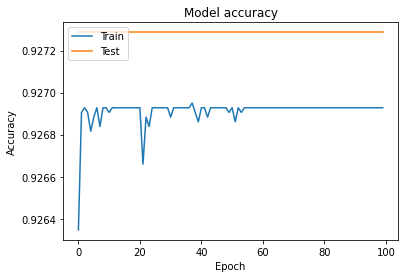

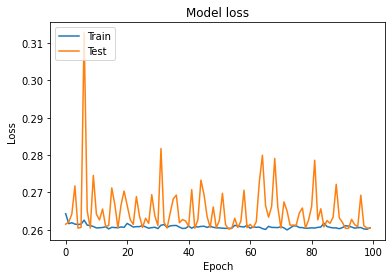

In [39]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
from datetime import date
from glob import glob
import datetime

In [41]:
from pandas_datareader import data as pdr
import pandas_datareader.data as web # ไลบรารีที่เราจะใช้ดึงข้อมูลหุ้น
from tqdm import tqdm,trange
stock_name = "SCB.BK" # ใส่ชื่อของหุ้นที่เราจะดึงข้อมูล ในที่นี้คือ SCB
start_date = date(2020,1,1) # กำหนดวันแรกที่จะดึงข้อมูล
end_date = datetime.datetime.now() # กำหนดวันสุดท้ายที่จะดึงข้อมูล
#ดึงข้อมูลมาเก็บไว้ในตัวแปร df
data = web.get_data_yahoo(stock_name, start_date, end_date)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-16,64.50,63.00,64.25,63.50,12106300.0,63.50
2020-10-19,62.75,60.00,62.75,60.75,20305500.0,60.75
2020-10-20,62.50,60.75,60.75,61.25,16932400.0,61.25
2020-10-21,65.25,61.75,62.25,65.00,19261400.0,65.00
2020-10-22,65.00,63.00,64.50,65.00,15519100.0,65.00


In [42]:
def ema(df_close, period=14, adjustment=True):  
  result = df_close.ewm(span=period, adjust=adjustment).mean()
  
  assert len(result) == len(df_close)
  return result
def macd(df_close, slow=26, fast=12):    
    emaslow = ema(df_close, period=slow)
    emafast = ema(df_close, period=fast)
    result = emafast - emaslow
    
    assert len(result) == len(df_close)
    return emaslow, emafast, result
def stoch(df_high, df_low, df_close):  
  #Create the "low period" the DataFrame
  df_low14 = df_low.rolling(window=14).min()

  #Create the "high period" the DataFrame
  df_high14 = df_high.rolling(window=14).max()

  #Create the "%K" the DataFrame
  df_percentK = 100*((df_close - df_low14) / (df_high14- df_low14) )
    
  #Create the "%D" the DataFrame
  df_percentD = df_percentK.rolling(window=3).mean()

  assert len(df_percentK) == len(df_close)
  assert len(df_percentD) == len(df_close)
  return df_percentK, df_percentD
def rsi(df_close, period=14, method="EMA"):
    result = pd.DataFrame(index = df_close.index, columns=['RSI'])
    
    # deffernt
    delta = df_close.diff().dropna()
    
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    if method=="EMA":
      # Calculate the EMA
      roll_up1 = up.ewm(span=period).mean()
      roll_down1 = down.abs().ewm(span=period).mean()
      
      # Calculate the RSI based on EMA
      RS1 = roll_up1 / roll_down1
      RSI1 = 100.0 - (100.0 / (1.0 + RS1))
      result['RSI'][1:]=RSI1 
      assert len(df_close) == len(RSI1)+1  

    if method=="SMA":
      # Calculate the SMA
      roll_up2 = up.rolling(window=period).mean()
      roll_down2 = down.abs().rolling(window=period).mean()
      
      # Calculate the RSI based on SMA
      RS2 = roll_up2 / roll_down2
      RSI2 = 100.0 - (100.0 / (1.0 + RS2))
      result['RSI'][1:]=RSI2 
      assert len(df_close) == len(RSI2)+1  
    
    return result['RSI']
def stoch_rsi(df_close, period=14, method="EMA"):
  df_rsi = rsi(df_close, period, method)
  assert len(df_rsi) == len(df_close)
  
  df_percentK, df_percentD = stoch(df_rsi, df_rsi, df_rsi)
  
  assert len(df_percentK) == len(df_close)
  assert len(df_percentD) == len(df_close)
  return df_percentK, df_percentD


In [43]:
def encode_diff(df_diff):
  df = pd.DataFrame(index=df_diff.index , columns=['encode'])
  df.encode[df_diff > 0] = 1.0    
  df.encode[df_diff == 0] = 0.5
  df.encode[df_diff < 0] = 0.0
  
  return df.encode

In [56]:
df = data
adj_close = df['Adj Close']

emaslow, emafast, ema_diff = macd(adj_close)

rsi_percentK, rsi_percentD = stoch_rsi(adj_close)
rsi_diff = rsi_percentK - rsi_percentD

open_close = df.Open-df.Close
open_closePrev = df.Open-df.Close.shift(1)

price_diff = df.diff()

df['macd'] = encode_diff(ema_diff)
df['rsi_diff'] = encode_diff(rsi_diff)
#df['open-close'] = encode_diff(open_close)
#df['open-close.prev'] = encode_diff(open_closePrev)

df['open_diff'] = encode_diff(price_diff.Open)
df['close_diff'] = encode_diff(price_diff.Close)
df['high_diff'] = encode_diff(price_diff.High)
df['low_diff'] = encode_diff(price_diff.Low)


signal = my_signal(adj_close)
signal = signal.shift(-2) # shift ขึ้นไปสองแถว
signal = signal.fillna(0) # ยังมี NaN อยู่แถวแรก แก้ให้เป็น 0
signal = signal[1:-2] # cut tail that is NaN

signal[signal==1] = 1 
signal[signal==2] = 2 
signal[signal==3] = 3 
signal[signal==4] = 4 # สนใจราคาขึ้นมากสุด 4 วันติดกัน

df_new = df[:] # ตัดให้เหลือแถวเท่ากับ signal
df_new = df_new.drop(columns=['High', 'Low',  'Open',  'Close',   'Volume'])
#print(table_signal.head())
print(df_new.tail(15))
print(df)
df_new
signal.tail(15)

            Adj Close macd rsi_diff open_diff close_diff high_diff low_diff
Date                                                                       
2020-10-01      64.75    0        0         0          0         0        1
2020-10-02      63.75    0        0         0          0         0        0
2020-10-05      64.25    0        1         0          1         1        1
2020-10-06      65.25    0        1         1          1         1        0
2020-10-07      65.50    0        1       0.5          1         0        1
2020-10-08      66.50    0        1         1          1         1        1
2020-10-09      66.00    0        0         1          0         0        0
2020-10-12      66.75    0        1         0          1         1        1
2020-10-14      64.25    0        0         0          0         0        0
2020-10-15      64.50    0        0         0          1         0        0
2020-10-16      63.50    0        0         1          0       0.5        1
2020-10-19  

Date
2020-09-29    0.0
2020-09-30    0.0
2020-10-01    1.0
2020-10-02    3.0
2020-10-05    4.0
2020-10-06    4.0
2020-10-07    3.0
2020-10-08    3.0
2020-10-09    1.0
2020-10-12    1.0
2020-10-14    1.0
2020-10-15    1.0
2020-10-16    1.0
2020-10-19    3.0
2020-10-20    3.0
Name: Adj Close, dtype: float64